In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf

df = pd.read_csv(r"C:\Users\m\Taha\Codebasics Challenges\Parliament Elections\LOK SABHA.csv")

In [2]:
df.head()

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors,Year,candidate_rank,pc_votes,pc_electors,state_votes,state_electors,party_votes,party_rank
0,Andhra Pradesh,Adilabad,Godam Nagesh,Male,49,ST,TRS,Car,425762,5085,430847,1386282,2014,1,1045839,12476538,48367188,1028145613,430847,1
1,Andhra Pradesh,Adilabad,Naresh,Male,37,ST,INC,Hand,257994,1563,259557,1386282,2014,2,1045839,12476538,48367188,1028145613,259557,2
2,Andhra Pradesh,Adilabad,Ramesh Rathod,Male,48,ST,TDP,Bicycle,182879,1319,184198,1386282,2014,3,1045839,12476538,48367188,1028145613,184198,3
3,Andhra Pradesh,Adilabad,Rathod Sadashiv,Male,55,ST,BSP,Elephant,94363,57,94420,1386282,2014,4,1045839,12476538,48367188,1028145613,94420,4
4,Andhra Pradesh,Adilabad,Nethawath Ramdas,Male,44,ST,IND,Auto- Rickshaw,41028,4,41032,1386282,2014,5,1045839,12476538,48367188,1028145613,59733,5


## 3. which consitituencies have elected the same party for two consecutive elections rank them by % of votes to that winning party in 2019

In [3]:
query = """
select 
    pc_name,
    sum(case when Year = 2014 then total_votes else 0 end) as pc_2014_votes,
    sum(case when Year = 2019 then total_votes else 0 end) as pc_2019_votes
from
    df
group by
    pc_name

"""
pc_votes = sqldf(query)
pc_votes.head()

,pc_name,pc_2014_votes,pc_2019_votes
0,Adilabad,1045839,1063730
1,Agra,1070400,1145323
2,Ahmadnagar,1062318,1203797
3,Ahmedabad East,985525,1116367
4,Ahmedabad West,964609,997024


In [4]:
query = """
select 
    *
from

(
select
    *,
    row_number() over(partition by pc_name order by total_2014_votes desc) as rank_2014,
    row_number() over(partition by pc_name order by total_2019_votes desc) as rank_2019
from

(
select 
    pc_name,
    party,
    sum(case when Year = 2014 then total_votes else 0 end) as total_2014_votes,
    sum(case when Year = 2019 then total_votes else 0 end) as total_2019_votes
from 
    df
group by 
    pc_name, party
                    ) as sub
                    ) as sub1
    
where 
    (rank_2014 = 1 and rank_2019 = 1) and (total_2014_votes <> 0 and total_2019_votes <> 0)
"""

winning_parties_in_2_elections = sqldf(query)
winning_parties_in_2_elections.head()

,pc_name,party,total_2014_votes,total_2019_votes,rank_2014,rank_2019
0,Agra,BJP,583716,646875,1,1
1,Ahmadnagar,BJP,605185,704660,1,1
2,Ahmedabad East,BJP,633582,749834,1,1
3,Ahmedabad West,BJP,617104,641622,1,1
4,Ajmer,BJP,637874,815076,1,1


In [5]:
Q3 = pd.merge(pc_votes, winning_parties_in_2_elections, on = 'pc_name')
Q3

,pc_name,pc_2014_votes,pc_2019_votes,party,total_2014_votes,total_2019_votes,rank_2014,rank_2019
0,Agra,1070400,1145323,BJP,583716,646875,1,1
1,Ahmadnagar,1062318,1203797,BJP,605185,704660,1,1
2,Ahmedabad East,985525,1116367,BJP,633582,749834,1,1
3,Ahmedabad West,964609,997024,BJP,617104,641622,1,1
4,Ajmer,1156314,1262214,BJP,637874,815076,1,1
...,...,...,...,...,...,...,...,...
325,Wardha,1013445,1072570,BJP,537518,578364,1,1
326,Wayanad,915006,1092197,INC,377035,706367,1,1
327,West Delhi,1347971,1441601,BJP,651395,865648,1,1
328,Yavatmal-Washim,1032949,1174220,SHS,477905,542098,1,1


In [6]:
Q3[['pc_name', 'party']].nunique()

pc_name    330
party       23
dtype: int64

In [7]:
query = """
select 
    *,
    row_number() over(order by `votes %` desc) as rank
from
(select
    pc_name,
    party,
    round((cast(total_2019_votes as real)/ pc_2019_votes) * 100, 2) as `votes %`
from
    Q3
group by
    pc_name, party
order by
    `votes %` desc
                    ) as sub

"""
Q3_res = sqldf(query)
Q3_res

,pc_name,party,votes %,rank
0,Surat,BJP,74.47,1
1,Navsari,BJP,74.37,2
2,Vadodara,BJP,72.30,3
3,Kangra,BJP,72.02,4
4,Bhilwara,BJP,71.59,5
...,...,...,...,...
325,Pathanamthitta,INC,37.11,326
326,Ludhiana,INC,36.66,327
327,Maldaha Dakshin,INC,34.73,328
328,Kokrajhar,IND,34.15,329


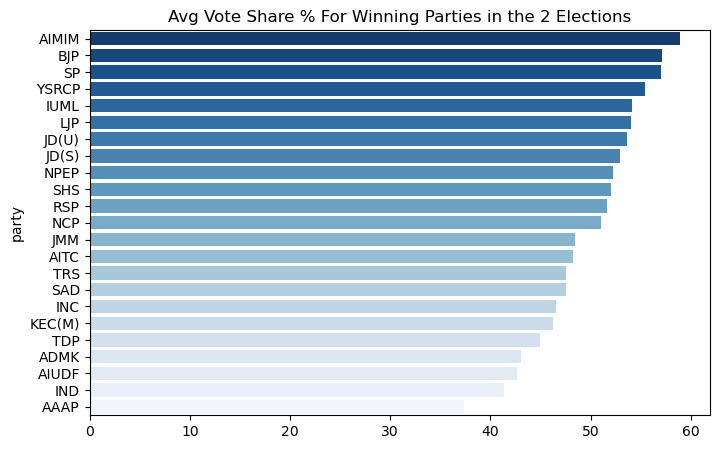

In [13]:
Q3_barchart = Q3_res.groupby('party')['votes %'].mean().sort_values(ascending = False)

plt.figure(figsize = (8,5))
sns.barplot( y = Q3_barchart.index, x = Q3_barchart.values, palette = "Blues_r")
plt.title('Avg Vote Share % For Winning Parties in the 2 Elections')
plt.show()

## 4. which constituencies have voted for different parties in two elections(list top 10 based on difference 19 - 14 in winner vote perc.

In [8]:
query = """
select 
    *
from
(
select
    *,
    row_number() over(partition by pc_name order by total_2014_votes desc) as rank_2014,
    row_number() over(partition by pc_name order by total_2019_votes desc) as rank_2019
from
(
select 
    pc_name,
    party,
    sum(case when Year = 2014 then total_votes else 0 end) as total_2014_votes,
    sum(case when Year = 2019 then total_votes else 0 end) as total_2019_votes
from 
    df
group by 
    pc_name, party
                        ) as sub 
                        ) as sub1
    
where 
    ((rank_2014 <> 1 and rank_2019 = 1)  or (rank_2014 = 1 and rank_2019 <> 1))
    and
    (total_2014_votes <> 0  and total_2019_votes <> 0)
"""

different_winners = sqldf(query)
different_winners.head()

,pc_name,party,total_2014_votes,total_2019_votes,rank_2014,rank_2019
0,Adilabad,TRS,430847,318814,1,2
1,Alappuzha,INC,462525,435496,1,2
2,Alathur,INC,374496,533815,2,1
3,Alipurduars,AITC,362453,506815,1,2
4,Alipurduars,BJP,335857,750804,3,1


In [9]:
Q4 = pd.merge(pc_votes, different_winners, on = 'pc_name')
Q4

,pc_name,pc_2014_votes,pc_2019_votes,party,total_2014_votes,total_2019_votes,rank_2014,rank_2019
0,Adilabad,1045839,1063730,TRS,430847,318814,1,2
1,Alappuzha,997464,1088728,INC,462525,435496,1,2
2,Alathur,927228,1018743,INC,374496,533815,2,1
3,Alipurduars,1223566,1380217,AITC,362453,506815,1,2
4,Alipurduars,1223566,1380217,BJP,335857,750804,3,1
...,...,...,...,...,...,...,...,...
276,Virudhunagar,1010930,1074735,INC,38482,470883,4,1
277,Visakhapatnam,1163558,1239754,BJP,566832,33892,1,4
278,Visakhapatnam,1163558,1239754,YSRCP,476344,436906,2,1
279,Vizianagaram,1120316,1217890,TDP,536549,530382,1,2


In [10]:
Q4[['pc_name', 'party']].nunique()

pc_name    164
party       34
dtype: int64

In [11]:
query = """
select 
    *,
    `votes_2019_%` - `votes_2014_%` as `votes_%_diff`
from
(
select 
    *,
    round((cast(total_2014_votes as real)/ pc_2014_votes) * 100, 2) as `votes_2014_%`,
    round((cast(total_2019_votes as real)/ pc_2019_votes) * 100, 2) as `votes_2019_%`
from 
    Q4
                ) as sub
order by
    `votes_%_diff` desc
limit 10
"""
Q4_res = sqldf(query)
Q4_res

,pc_name,pc_2014_votes,pc_2019_votes,party,total_2014_votes,total_2019_votes,rank_2014,rank_2019,votes_2014_%,votes_2019_%,votes_%_diff
0,Karur,1046534,1103165,INC,30459,695697,4,1,2.91,63.06,60.15
1,Mandya,1192638,1379210,IND,15959,769195,5,1,1.34,55.77,54.43
2,Tiruchirappalli,988250,1048062,INC,51537,621285,4,1,5.21,59.28,54.07
3,Giridih,969997,1106918,AJSUP,55531,648277,4,1,5.72,58.57,52.85
4,Arani,1096046,1143907,INC,27717,617760,5,1,2.53,54.00,51.47
5,Thiruvallur,1254440,1408189,INC,43960,767292,4,1,3.50,54.49,50.99
6,Valmiki Nagar,900127,1032090,JD(U),81612,602660,4,1,9.07,58.39,49.32
7,Krishnagiri,1068391,1161369,INC,38885,611298,4,1,3.64,52.64,49.00
8,Tripura West,1072749,1107755,BJP,54706,573532,4,1,5.10,51.77,46.67
9,Bhagalpur,974016,1042518,JD(U),132256,618254,3,1,13.58,59.30,45.72


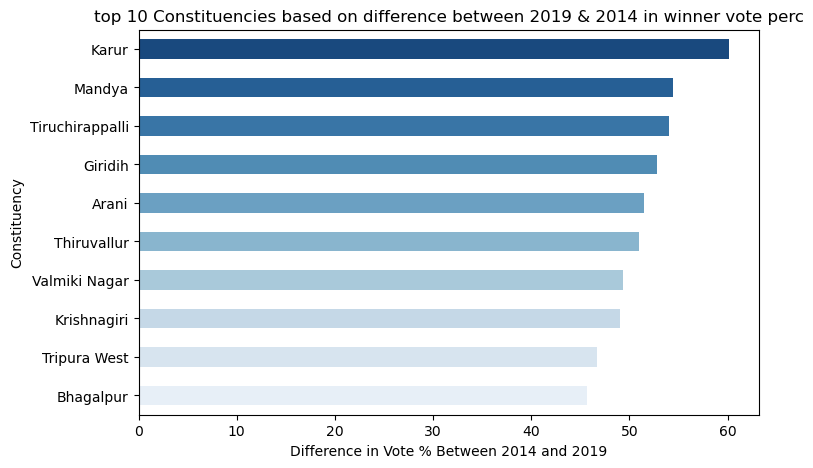

In [12]:
plt.figure(figsize = (8,5))
sns.barplot(data = Q4_res, y = 'pc_name', x = 'votes_%_diff', palette = 'Blues_r', width = .5)
plt.xlabel('Difference in Vote % Between 2014 and 2019')
plt.ylabel('Constituency')
plt.title("top 10 Constituencies based on difference between 2019 & 2014 in winner vote perc")
plt.show()

# Excluded Constituencies
- Constituencies that have data for only one of the two rounds

In [20]:
query = """
select * from
(
select
    *,
    row_number() over(partition by pc_name order by total_2014_votes desc) as rank_2014,
    row_number() over(partition by pc_name order by total_2019_votes desc) as rank_2019
from

(
select 
    pc_name,
    party,
    sum(case when Year = 2014 then total_votes else 0 end) as total_2014_votes,
    sum(case when Year = 2019 then total_votes else 0 end) as total_2019_votes
from 
    df
group by 
    pc_name, party
                    ) as sub
     
                    ) as sub1
where
     (rank_2019 = 1 or rank_2014 = 1)
     and
     (total_2019_votes = 0 or total_2014_votes = 0)
"""

exluded_constituencies = sqldf(query)
exluded_constituencies

,pc_name,party,total_2014_votes,total_2019_votes,rank_2014,rank_2019
0,Adilabad,BJP,0,377374,7,1
1,Alappuzha,CPIM,0,445970,10,1
2,Alathur,CPM,411808,0,1,8
3,Arakkonam,ADMK,493534,0,1,10
4,Aska,BJD,0,552749,1,1
...,...,...,...,...,...,...
105,Tumkur,INC,429868,0,1,11
106,Valmiki Nagar,BJP,364013,0,1,15
107,Vellore,DMK,0,485340,13,1
108,Viluppuram,ADMK,482704,0,1,10


In [21]:
exluded_constituencies[['pc_name', 'party']].nunique()

pc_name    98
party      24
dtype: int64

## 8. list top 5 constituencies for two major national parties where they have gained vote share in 19 as compared to 14

In [66]:
query = """
select *
from
(select 
    *,
    row_number() over(partition by party order by vote_diff desc) as cons_rank
from

(select 
    *,
    pc_2019_votes - pc_2014_votes as vote_diff
from

(select
    party,
    pc_name,
    sum(case when Year = 2014 then total_votes else 0 end) as pc_2014_votes,
    sum(case when Year = 2019 then total_votes else 0 end) as pc_2019_votes
from
    df
where
    party = 'BJP' or party = 'INC'
group by
    party, pc_name
                        ) as sub
                        ) as sub1
    where pc_2014_votes <> 0
                        ) as sub2
where 
    cons_rank between 1 and 5

"""
major_parties = sqldf(query)
major_parties

,party,pc_name,pc_2014_votes,pc_2019_votes,vote_diff,cons_rank
0,BJP,Purulia,86236,668107,581871,1
1,BJP,Ranaghat,233670,783253,549583,2
2,BJP,Jalpaiguri,221593,760145,538552,3
3,BJP,Tripura West,54706,573532,518826,4
4,BJP,Ghatal,94842,609986,515144,5
5,INC,Thiruvallur,43960,767292,723332,1
6,INC,Karur,30459,695697,665238,2
7,INC,Arani,27717,617760,590043,3
8,INC,Krishnagiri,38885,611298,572413,4
9,INC,Tiruchirappalli,51537,621285,569748,5


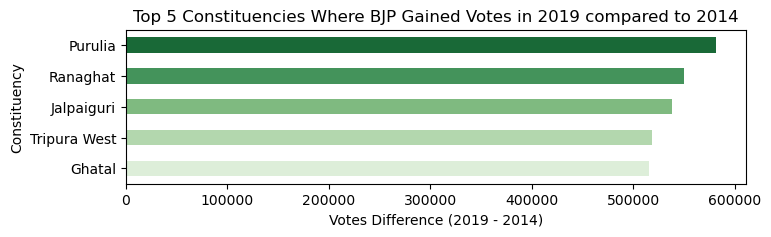

In [67]:
plt.figure(figsize = (8,2))
sns.barplot(data = major_parties[major_parties['party'] == 'BJP'],
           y = 'pc_name', x = 'vote_diff', palette = 'Greens_r', width = .5)
plt.ylabel('Constituency')
plt.xlabel('Votes Difference (2019 - 2014)')
plt.title('Top 5 Constituencies Where BJP Gained Votes in 2019 compared to 2014')
plt.show()

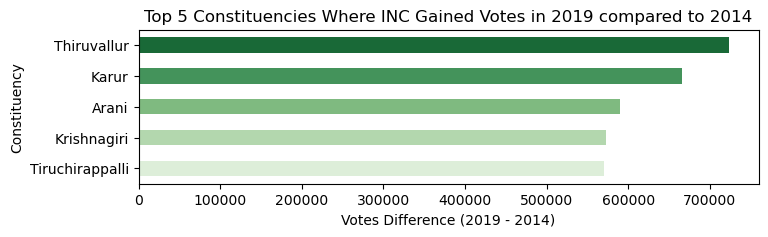

In [68]:
plt.figure(figsize = (8,2))
sns.barplot(data = major_parties[major_parties['party'] == 'INC'],
           y = 'pc_name', x = 'vote_diff', palette = 'Greens_r', width = .5)
plt.ylabel('Constituency')
plt.xlabel('Votes Difference (2019 - 2014)')
plt.title('Top 5 Constituencies Where INC Gained Votes in 2019 compared to 2014')
plt.show()

## 9. list top 5 constituencies for two major national parties where they have lost vote share in 19 as compared to 14

In [69]:
query = """

select 
    *,
    pc_2019_votes - pc_2014_votes as vote_diff
from

(select
    party,
    pc_name,
    sum(case when Year = 2014 then total_votes else 0 end) as pc_2014_votes,
    sum(case when Year = 2019 then total_votes else 0 end) as pc_2019_votes
from
    df
where
    party = 'BJP' or party = 'INC'
group by
    party, pc_name
                            ) as sub
    where pc_2019_votes <> 0
order by
    vote_diff asc
"""
major_parties_lost = sqldf(query)
major_parties_lost

,party,pc_name,pc_2014_votes,pc_2019_votes,vote_diff
0,BJP,Visakhapatnam,566832,33892,-532940
1,BJP,Narsapuram,540306,12414,-527892
2,BJP,Tirupati,542951,16125,-526826
3,INC,Aurangabad,600496,91789,-508707
4,INC,Ratnagiri - Sindhudurg,343037,63299,-279738
...,...,...,...,...,...
849,INC,Karur,30459,695697,665238
850,BJP,Sirsa,0,714351,714351
851,INC,Thiruvallur,43960,767292,723332
852,BJP,Raipur,0,837902,837902


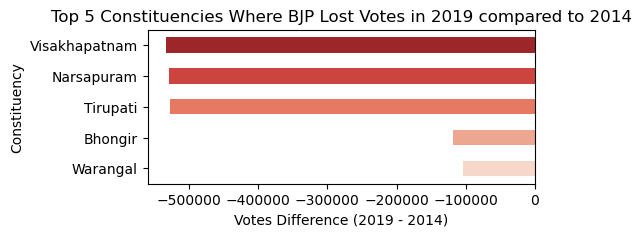

In [70]:
plt.figure(figsize = (5,2))
sns.barplot(data = major_parties_lost[major_parties_lost['party'] == 'BJP'][:5],
           y = 'pc_name', x = 'vote_diff', palette = 'Reds_r', width = .5)
plt.ylabel('Constituency')
plt.xlabel('Votes Difference (2019 - 2014)')
plt.title('Top 5 Constituencies Where BJP Lost Votes in 2019 compared to 2014')
plt.show()

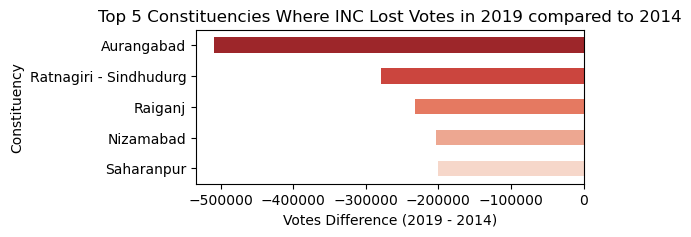

In [71]:
plt.figure(figsize = (5,2))
sns.barplot(data = major_parties_lost[major_parties_lost['party'] == 'INC'][:5],
           y = 'pc_name', x = 'vote_diff', palette = 'Reds_r', width = .5)
plt.ylabel('Constituency')
plt.xlabel('Votes Difference (2019 - 2014)')
plt.title('Top 5 Constituencies Where INC Lost Votes in 2019 compared to 2014')
plt.show()

## 11. which constituency have elected candidates whose party has less than 10% vote share at state level in 2019

In [78]:
df_2014 = df[df['Year'] == 2014]
df_2019 = df[df['Year'] == 2019]

In [79]:
query = """
select * 
from
(
select
    state,
    party,
    round(((cast(party_state_2019_votes as real)/state_2019_votes) * 100),2) as party_state_2019_perc
from
    state_level
                    ) as sub
    
where 
    party_state_2019_perc < 10
order by
    party_state_2019_perc desc
"""
parties_with_less_than_10_perc_vote_share = sqldf(query)
parties_with_less_than_10_perc_vote_share

,state,party,party_state_2019_perc
0,Karnataka,JD(S),9.67
1,Punjab,BJP,9.63
2,Arunachal Pradesh,JD(S),9.18
3,Manipur,CPI,8.27
4,Assam,AGP,8.23
...,...,...,...
1854,West Bengal,STPI,0.00
1855,West Bengal,SUCI,0.00
1856,West Bengal,SWJP,0.00
1857,West Bengal,TRMRPPI,0.00


In [80]:
parties_with_less_than_10_perc_vote_share['party'].nunique()

889

In [81]:
query = """
select 
    * 
from
(
select
    *,
    row_number() over(partition by pc_name order by candidate_votes desc) as candidate_rank
from
(
select
    state,
    pc_name,
    party,
    candidate,
    sum(total_votes) as candidate_votes
from
    df_2019
group by
    state, pc_name, party, candidate
                                ) as sub
                                ) as sub1
where 
    candidate_rank = 1

"""
winners_2019 = sqldf(query)
winners_2019

,state,pc_name,party,candidate,candidate_votes,candidate_rank
0,Telangana,Adilabad,BJP,Soyam Bapu Rao,377374,1
1,Uttar Pradesh,Agra,BJP,Satyapal Singh Baghel,646875,1
2,Maharashtra,Ahmadnagar,BJP,Dr. Sujay Radhakrishna Vikhepatil,704660,1
3,Gujarat,Ahmedabad East,BJP,Patel Hasmukhbhai Somabhai,749834,1
4,Gujarat,Ahmedabad West,BJP,Dr. Kirit P. Solanki,641622,1
...,...,...,...,...,...,...
535,Maharashtra,Wardha,BJP,Ramdas Chandrabhanji Tadas,578364,1
536,Kerala,Wayanad,INC,Rahul Gandhi,706367,1
537,Nct Of Delhi,West Delhi,BJP,Parvesh Sahib Singh Verma,865648,1
538,Maharashtra,Yavatmal-Washim,SHS,Bhavana Pundlikrao Gawali,542098,1


In [82]:
winners_2019_parties = winners_2019['party'].unique()
len(winners_2019_parties)

37

In [83]:
Q11 = pd.merge(winners_2019,parties_with_less_than_10_perc_vote_share, on = ['state', 'party'], how = 'inner' )
Q11

,state,pc_name,party,candidate,candidate_votes,candidate_rank,party_state_2019_perc
0,Maharashtra,Amravati,IND,Navnit Ravi Rana,510947,1,3.68
1,Jammu & Kashmir,Anantnag,JKN,Hasnain Masoodi,40180,1,7.89
2,Jammu & Kashmir,Baramulla,JKN,Mohammad Akbar Lone,133426,1,7.89
3,Jammu & Kashmir,Srinagar,JKN,Farooq Abdullah,106750,1,7.89
4,West Bengal,Baharampur,INC,Adhir Ranjan Chowdhury,591106,1,5.61
5,West Bengal,Maldaha Dakshin,INC,Abu Hasem Khan Chowdhury (Dalu),444270,1,5.61
6,Tamil Nadu,Chidambaram,VCK,Thirumaavalavan Thol,500229,1,1.15
7,Tamil Nadu,Coimbatore,CPIM,Natarajan. P.R,571150,1,2.35
8,Tamil Nadu,Madurai,CPIM,Venkatesan S,447075,1,2.35
9,Assam,Dhubri,AIUDF,Badruddin Ajmal,718764,1,7.80


In [84]:
Q11.nunique()

state                    13
pc_name                  36
party                    18
candidate                36
candidate_votes          36
candidate_rank            1
party_state_2019_perc    23
dtype: int64